## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [2]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'D:\\file_yyux\\UCLA\\23W-courses\\C247\\cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [4]:
from nndl import Softmax

In [5]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [6]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [7]:
print(loss)

2.3277607028048757


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

We haven't figured out the optimal parameters here.

#### Softmax gradient

In [8]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 0.598673 analytic: 0.598673, relative error: 4.963857e-08
numerical: 0.241832 analytic: 0.241832, relative error: 3.677000e-08
numerical: -0.894712 analytic: -0.894712, relative error: 1.918034e-08
numerical: 0.229940 analytic: 0.229940, relative error: 4.938331e-08
numerical: 0.748574 analytic: 0.748574, relative error: 3.954702e-08
numerical: 0.770986 analytic: 0.770986, relative error: 9.470036e-09
numerical: -0.919696 analytic: -0.919696, relative error: 5.389844e-08
numerical: -0.363270 analytic: -0.363270, relative error: 8.098359e-09
numerical: 0.326937 analytic: 0.326937, relative error: 1.728843e-08
numerical: -3.850430 analytic: -3.850431, relative error: 2.078891e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [9]:
import time

In [10]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3259145019892684 / 341.43965400563695 computed in 0.02105426788330078s
Vectorized loss / grad: 2.3259145019892657 / 341.439654005637 computed in 0.0020055770874023438s
difference in loss / grad: 2.6645352591003757e-15 /5.1949918658072915e-14 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.32404675150806
iteration 100 / 1500: loss 2.061522973191748
iteration 200 / 1500: loss 1.982229019429444
iteration 300 / 1500: loss 1.9267805465258758
iteration 400 / 1500: loss 1.9217010353302473
iteration 500 / 1500: loss 1.890920656263819
iteration 600 / 1500: loss 1.8771114413158583
iteration 700 / 1500: loss 1.8711568424573894
iteration 800 / 1500: loss 1.8356914360003804
iteration 900 / 1500: loss 1.845429490501734
iteration 1000 / 1500: loss 1.873091370521568
iteration 1100 / 1500: loss 1.8423617955326128
iteration 1200 / 1500: loss 1.818357106153725
iteration 1300 / 1500: loss 1.8261028275903577
iteration 1400 / 1500: loss 1.8037723054429455
That took 44.32196044921875s


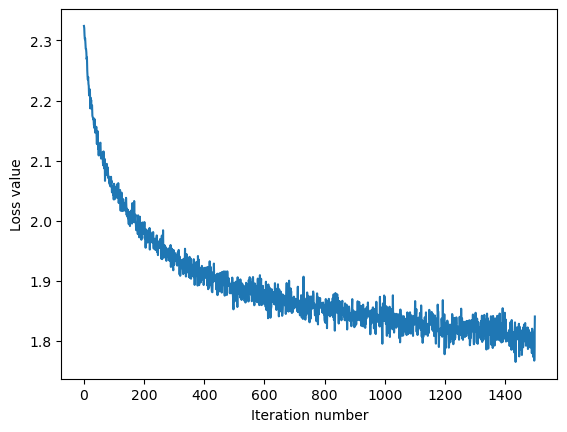

In [11]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [12]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3816530612244898
validation accuracy: 0.398


## Optimize the softmax classifier

In [13]:
np.finfo(float).eps

2.220446049250313e-16

In [14]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
results = {}
best_val = -1
best_lr = None

lrs = [1e-9, 1e-7, 5e-7]
for lr in lrs:
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr,
                                 num_iters=1500, verbose=True)
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    val_error = 1 - val_accuracy
    results[(lr)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_lr = softmax
best_error = 1 - best_val
# Print out results.
for lr in sorted(results):
    train_accuracy, val_accuracy = results[(lr)]
    print('lr %e train accuracy: %f val accuracy: %f' % (
        lr, train_accuracy, val_accuracy))
print('So best learning rate: %e best validation accuracy: %f with corresponding best error: %f' %(
    lrs[2], best_val, best_error) )
y_test_pred = softmax.predict(X_test)
test_error = 1 - np.mean(y_test == y_test_pred)
print("The test error is : %f" % test_error)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


iteration 0 / 1500: loss 2.3766813737240655
iteration 100 / 1500: loss 2.365463948404861
iteration 200 / 1500: loss 2.3545622828650883
iteration 300 / 1500: loss 2.342590960381115
iteration 400 / 1500: loss 2.33888103045761
iteration 500 / 1500: loss 2.324218911289491
iteration 600 / 1500: loss 2.3205120923661102
iteration 700 / 1500: loss 2.315644496902952
iteration 800 / 1500: loss 2.3013654949754314
iteration 900 / 1500: loss 2.286922961766898
iteration 1000 / 1500: loss 2.2776902380294652
iteration 1100 / 1500: loss 2.284785742305509
iteration 1200 / 1500: loss 2.277286811866825
iteration 1300 / 1500: loss 2.2704933657110242
iteration 1400 / 1500: loss 2.2644582428121542
iteration 0 / 1500: loss 2.361431595428404
iteration 100 / 1500: loss 2.073994686155015
iteration 200 / 1500: loss 2.011725556797849
iteration 300 / 1500: loss 1.9549045659448887
iteration 400 / 1500: loss 1.9375899683241176
iteration 500 / 1500: loss 1.890382770402676
iteration 600 / 1500: loss 1.8685690350530668
